# Autotalker

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 13.01.2023
- **Date of Last Modification:** 04.03.2023

- The Autotalker source code is available at https://github.com/Talavera-Lopez-Lab/autotalker.
- The workflow of this notebook follows the tutorial from https://github.com/sebastianbirk/autotalker/blob/main/notebooks/autotalker_tutorial.ipynb.
- It is recommended to use raw counts as input to Autotalker. Therefore, we use raw counts (stored in adata.X).

## 1. Setup

### 1.1 Import Libraries

In [1]:
import sys
sys.path.append("../../../autotalker")

In [2]:
import argparse
import os
import random
import time
import warnings
from copy import deepcopy
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq
import torch
from matplotlib.pyplot import rc_context

from autotalker.models import Autotalker
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps)

### 1.2 Define Parameters

In [3]:
model_name = "autotalker"
latent_key = f"{model_name}_latent"
leiden_resolution = 0.01 # used for Leiden clustering of latent space; 0.1
random_seed = 0 # used for Leiden clustering

### 1.3 Run Notebook Setup

In [4]:
sc.set_figure_params(figsize=(6, 6))

In [5]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Directories

In [6]:
data_folder_path = "../../datasets/srt_data/gold/"
figure_folder_path = f"../../figures"
gp_data_folder_path = "../../datasets/gp_data" # gene program data
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"

# Create required directories
os.makedirs(gp_data_folder_path, exist_ok=True)

## 2. Autotalker Model

### 2.1 Prepare Gene Program Mask

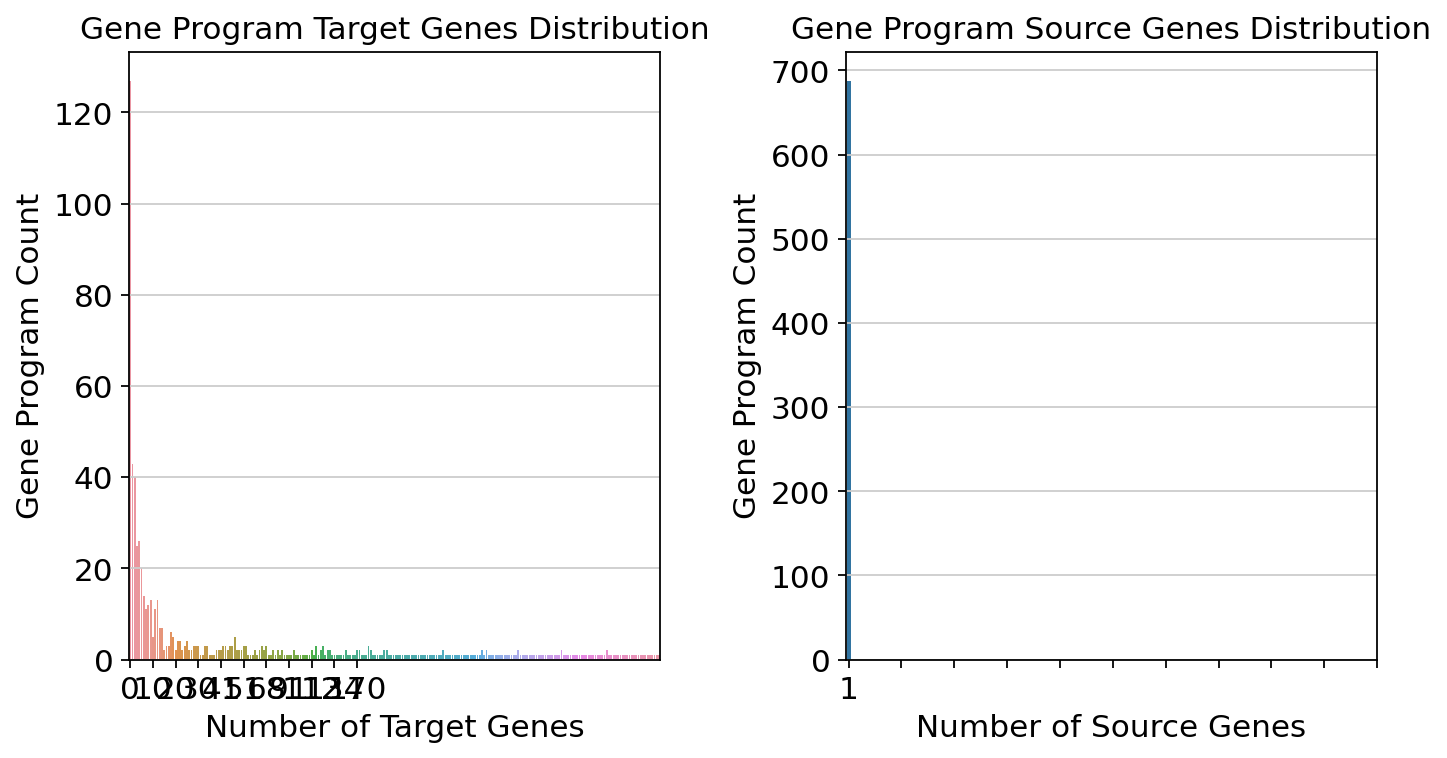

In [7]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_genes_ratio=0.01,
    max_n_target_genes_per_gp=20000,
    load_from_disk=False,
    save_to_disk=False,
    file_path=nichenet_ligand_target_mx_file_path)

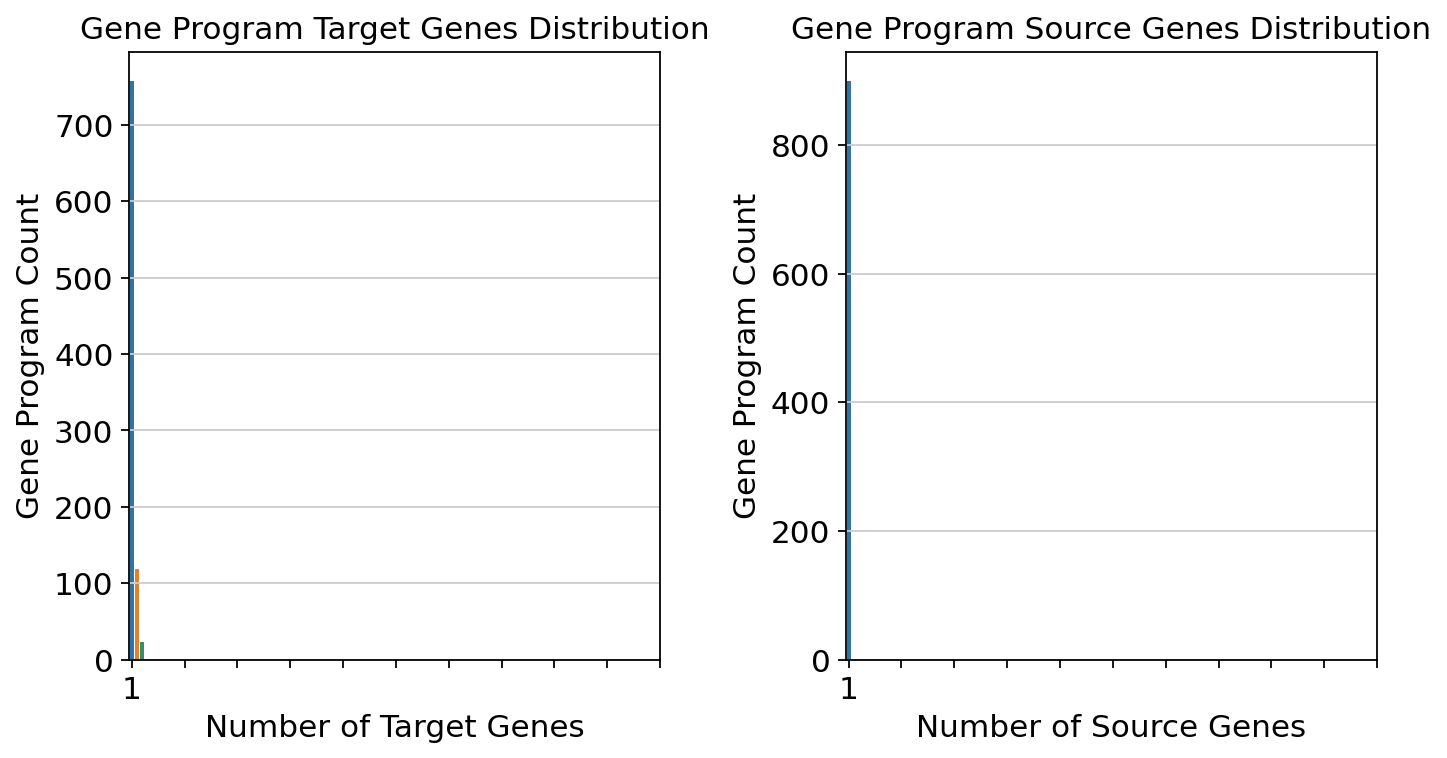

In [8]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=False,
    file_path=omnipath_lr_interactions_file_path)

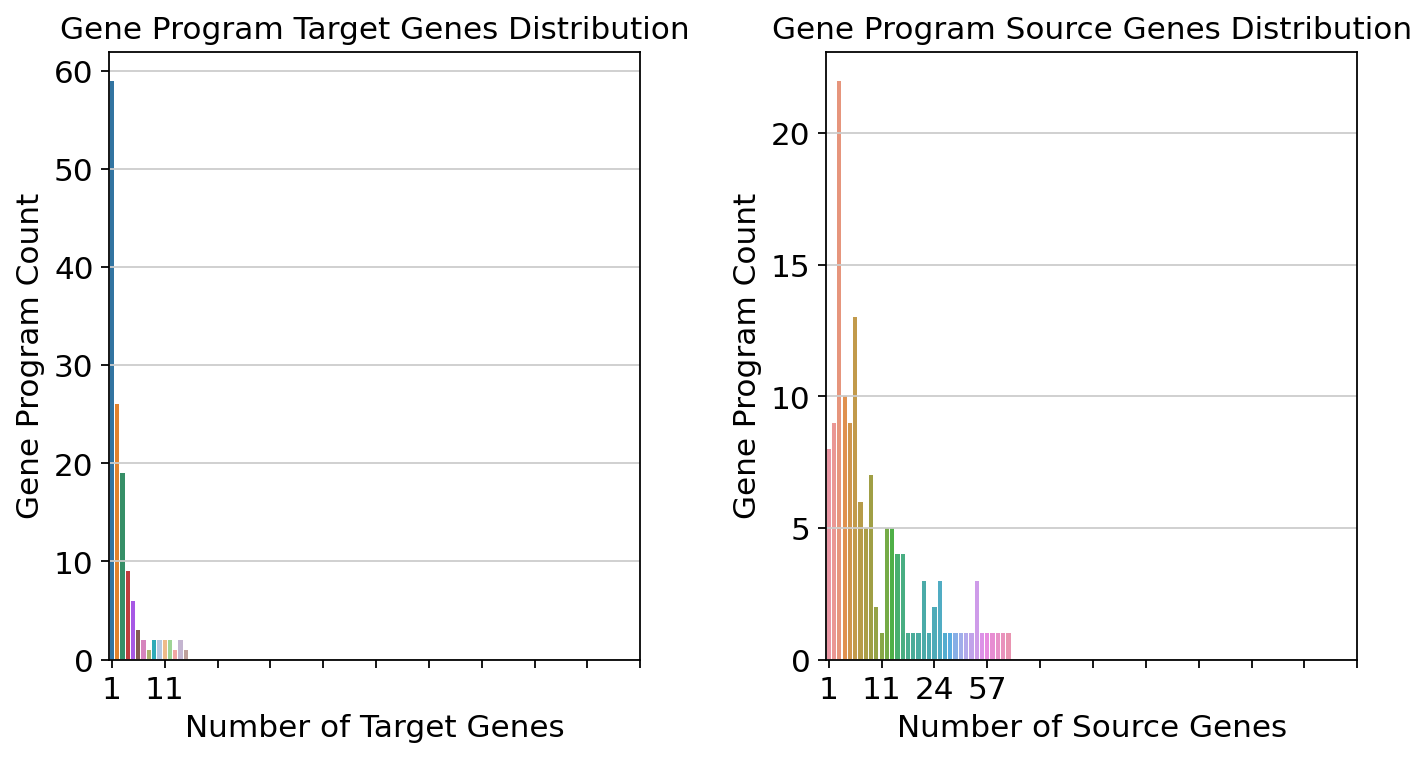

In [9]:
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps/",
    species="mouse",
    genes_uppercase=True)

In [10]:
# Combine gene programs into one dictionary
combined_gp_dict = dict(nichenet_gp_dict)
combined_gp_dict.update(omnipath_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)

In [11]:
# Filter and combine gene programs
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset", #None,
    combine_overlap_gps=True, #True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9,
    verbose=True)

print(f"Number of gene programs before filtering and combining: {len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: {len(combined_new_gp_dict)}.")

Removing GP 'CTF1_ligand_receptor_GP' as it is a subset of GP 'CTF1_ligand_targetgenes_GP'.
Removing GP 'LEP_ligand_receptor_GP' as it is a subset of GP 'LEP_ligand_targetgenes_GP'.
Removing GP 'IL4_ligand_receptor_GP' as it is a subset of GP 'IL4_ligand_targetgenes_GP'.
Removing GP 'IL12A_ligand_receptor_GP' as it is a subset of GP 'IL12A_ligand_targetgenes_GP'.
Removing GP 'IL23A_ligand_receptor_GP' as it is a subset of GP 'IL23A_ligand_targetgenes_GP'.
Removing GP 'CSF2_ligand_receptor_GP' as it is a subset of GP 'CSF2_ligand_targetgenes_GP'.
Removing GP 'IL21_ligand_receptor_GP' as it is a subset of GP 'IL21_ligand_targetgenes_GP'.
Removing GP 'TSLP_ligand_receptor_GP' as it is a subset of GP 'TSLP_ligand_targetgenes_GP'.
Removing GP 'GH2_ligand_receptor_GP' as it is a subset of GP 'GH2_ligand_targetgenes_GP'.
Removing GP 'EGF_ligand_receptor_GP' as it is a subset of GP 'EGF_ligand_targetgenes_GP'.
Removing GP 'IL10_ligand_receptor_GP' as it is a subset of GP 'IL10_ligand_targetgen

### 2.2 Define Training Function

In [12]:
def train_autotalker_models(dataset,
                            cell_type_key,
                            adata_new=None,
                            n_start_run=1,
                            n_end_run=10,
                            n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20],
                            plot_latent_umaps: bool=False):
    # Configure figure folder path
    dataset_figure_folder_path = f"{figure_folder_path}/{dataset}/method_benchmarking/" \
                                 f"{model_name}/{current_timestamp}"
    os.makedirs(dataset_figure_folder_path, exist_ok=True)
    
    # Create new adata to store results from training runs in storage-efficient way
    if adata_new is None:
        adata_original = sc.read_h5ad(data_folder_path + f"{dataset}.h5ad")
        adata_new = sc.AnnData(sp.csr_matrix(
            (adata_original.shape[0], adata_original.shape[1]),
            dtype=np.float32))
        adata_new.obs["cell_type"] = adata_original.obs[cell_type_key].values
        del(adata_original)
    
    model_seeds = list(range(10))
    for run_number, n_neighbors in zip(np.arange(n_start_run, n_end_run+1), n_neighbor_list):
        # Load data
        adata = sc.read_h5ad(data_folder_path + f"{dataset}.h5ad")
        
        adata.obs["batch"] == "batch1"
        
        # Add the gene program dictionary as binary masks to the adata for model training
        add_gps_from_gp_dict_to_adata(
            gp_dict=combined_new_gp_dict,
            adata=adata,
            genes_uppercase=True,
            gp_targets_mask_key="autotalker_gp_targets",
            gp_sources_mask_key="autotalker_gp_sources",
            gp_names_key="autotalker_gp_names",
            min_genes_per_gp=1,
            min_source_genes_per_gp=0,
            min_target_genes_per_gp=0,
            max_genes_per_gp=None,
            max_source_genes_per_gp=None,
            max_target_genes_per_gp=None)

        # Determine dimensionality of hidden encoder
        n_hidden_encoder = len(adata.uns[f"{model_name}_gp_names"])

        # Compute spatial neighborhood graph
        sq.gr.spatial_neighbors(adata,
                                coord_type="generic",
                                spatial_key="spatial",
                                n_neighs=n_neighbors)

        # Make adjacency matrix symmetric
        adata.obsp["spatial_connectivities"] = (
            adata.obsp["spatial_connectivities"].maximum(
            adata.obsp["spatial_connectivities"].T))

        start_time = time.time()
        
        # Initialize model
        model = Autotalker(adata,
                           counts_key="counts",
                           adj_key="spatial_connectivities",
                           condition_key="batch",
                           cond_embed_injection=["gene_expr_decoder",
                                                 "graph_decoder"],
                           n_cond_embed=20,
                           gp_names_key="autotalker_gp_names",
                           active_gp_names_key="autotalker_active_gp_names",
                           gp_targets_mask_key="autotalker_gp_targets",
                           gp_sources_mask_key="autotalker_gp_sources",
                           latent_key=latent_key,
                           active_gp_thresh_ratio=0.03,
                           gene_expr_recon_dist="nb",
                           n_layers_encoder=1,
                           n_hidden_encoder=n_hidden_encoder,
                           log_variational=True)
        print("")

        # Train model
        model.train(n_epochs=40,
                    n_epochs_all_gps=20,
                    lr=0.001,
                    lambda_edge_recon=1000., # 0.01
                    lambda_gene_expr_recon=1., # 0.0033
                    lambda_l1_masked=0,
                    lambda_group_lasso=0,
                    edge_batch_size=64,
                    node_batch_size=8,
                    seed=model_seeds[run_number-1],
                    verbose=True)
        
        # Measure time for model training
        end_time = time.time()
        elapsed_time = end_time - start_time
        hours, rem = divmod(elapsed_time, 3600)
        minutes, seconds = divmod(rem, 60)
        print(f"Duration of model training in run {run_number}: "
              f"{int(hours)} hours, {int(minutes)} minutes and {int(seconds)} seconds.")
        adata_new.uns[f"{model_name}_model_training_duration_run{run_number}"] = (
            elapsed_time)

        if plot_latent_umaps:
            # Use Autotalker latent space for UMAP generation
            sc.pp.neighbors(adata,
                            use_rep=latent_key,
                            n_neighbors=n_neighbors)
            sc.tl.umap(adata)
            fig = sc.pl.umap(adata,
                             color=[cell_type_key],
                             title=f"Latent Space with Cell Types: {model_name.capitalize()}",
                             return_fig=True)
            fig.savefig(f"{dataset_figure_folder_path}/latent_{model_name}"
                        f"_cell_types_run{run_number}.png",
                        bbox_inches="tight")

            # Compute latent Leiden clustering
            sc.tl.leiden(adata=adata,
                         resolution=leiden_resolution,
                         random_state=random_seed,
                         key_added=f"latent_{model_name}_leiden_{str(leiden_resolution)}")

            # Create subplot of latent Leiden cluster annotations in physical and latent space
            fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 12))
            title = fig.suptitle(t="Latent and Physical Space with Leiden Clusters: "
                                   f"{model_name.capitalize()}")
            sc.pl.umap(adata=adata,
                       color=[f"latent_{model_name}_leiden_{str(leiden_resolution)}"],
                       title=f"Latent Space with Leiden Clusters",
                       ax=axs[0],
                       show=False)
            sq.pl.spatial_scatter(adata=adata,
                                  color=[f"latent_{model_name}_leiden_{str(leiden_resolution)}"],
                                  title=f"Physical Space with Leiden Clusters",
                                  shape=None,
                                  ax=axs[1])

            # Create and position shared legend
            handles, labels = axs[0].get_legend_handles_labels()
            lgd = fig.legend(handles, labels, bbox_to_anchor=(1.25, 0.9185))
            axs[0].get_legend().remove()
            axs[1].get_legend().remove()

            # Adjust, save and display plot
            plt.subplots_adjust(wspace=0, hspace=0.2)
            fig.savefig(f"{dataset_figure_folder_path}/latent_physical_comparison_"
                        f"{model_name}_run{run_number}.png",
                        bbox_extra_artists=(lgd, title),
                        bbox_inches="tight")
            plt.show()

        # Store latent representation
        adata_new.obsm[latent_key + f"_run{run_number}"] = adata.obsm[latent_key]

        # Store intermediate adata to disk
        adata_new.write(f"{data_folder_path}/{dataset}_{model_name}.h5ad")

    # Store final adata to disk
    adata_new.write(f"{data_folder_path}/{dataset}_{model_name}.h5ad")    

### 2.3 Train Models on Benchmarking Datasets

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
CONDITIONAL EMBEDDING INJECTION -> ['encoder', 'gene_expr_decoder', 'graph_decoder']
GRAPH ENCODER -> n_input: 351, n_cond_embed_input: 3, n_layers: 2, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
COSINE SIM GRAPH DECODER -> n_cond_embed_input: 3, n_output: 489, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_cond_embed_input: 3, n_addon_input: 0, n_output: 702

--- INITIALIZING TRAINER ---
Number of training nodes: 12767
Number of validation nodes: 1418
Number of training edges: 30388
Number of validation edges: 3376

--- MODEL TRAINING ---
Epoch 1/40 |--------------------| 2.5% val_auroc_score: 0.9876; val_auprc_score: 0.985

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


ValueError: Categorical categories must be unique

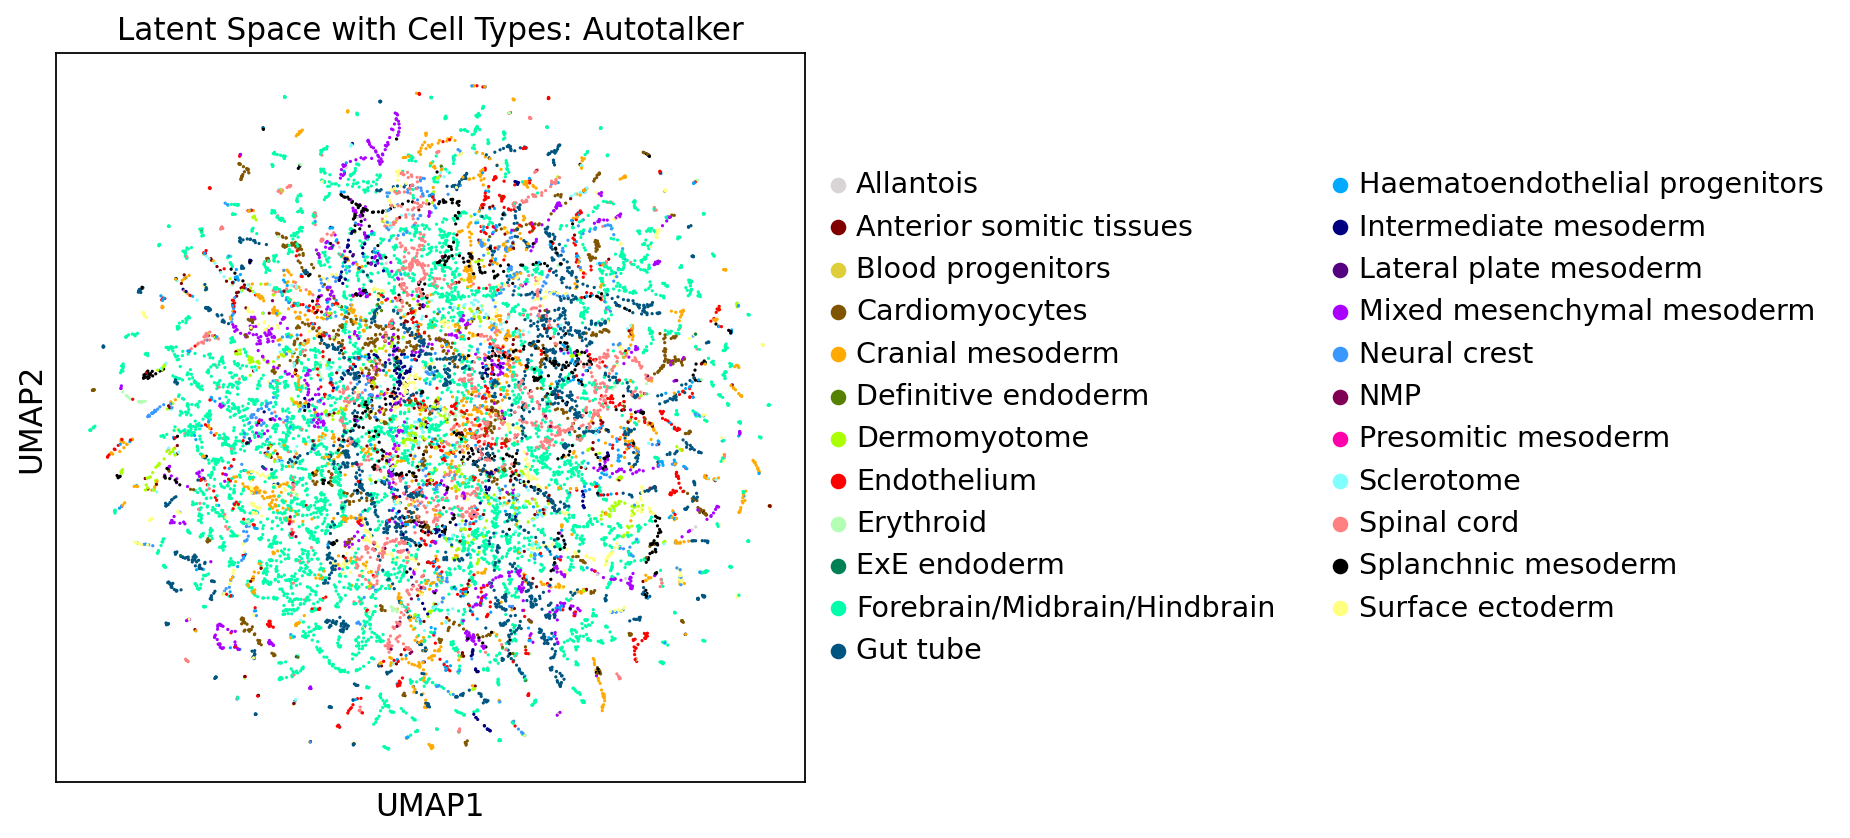

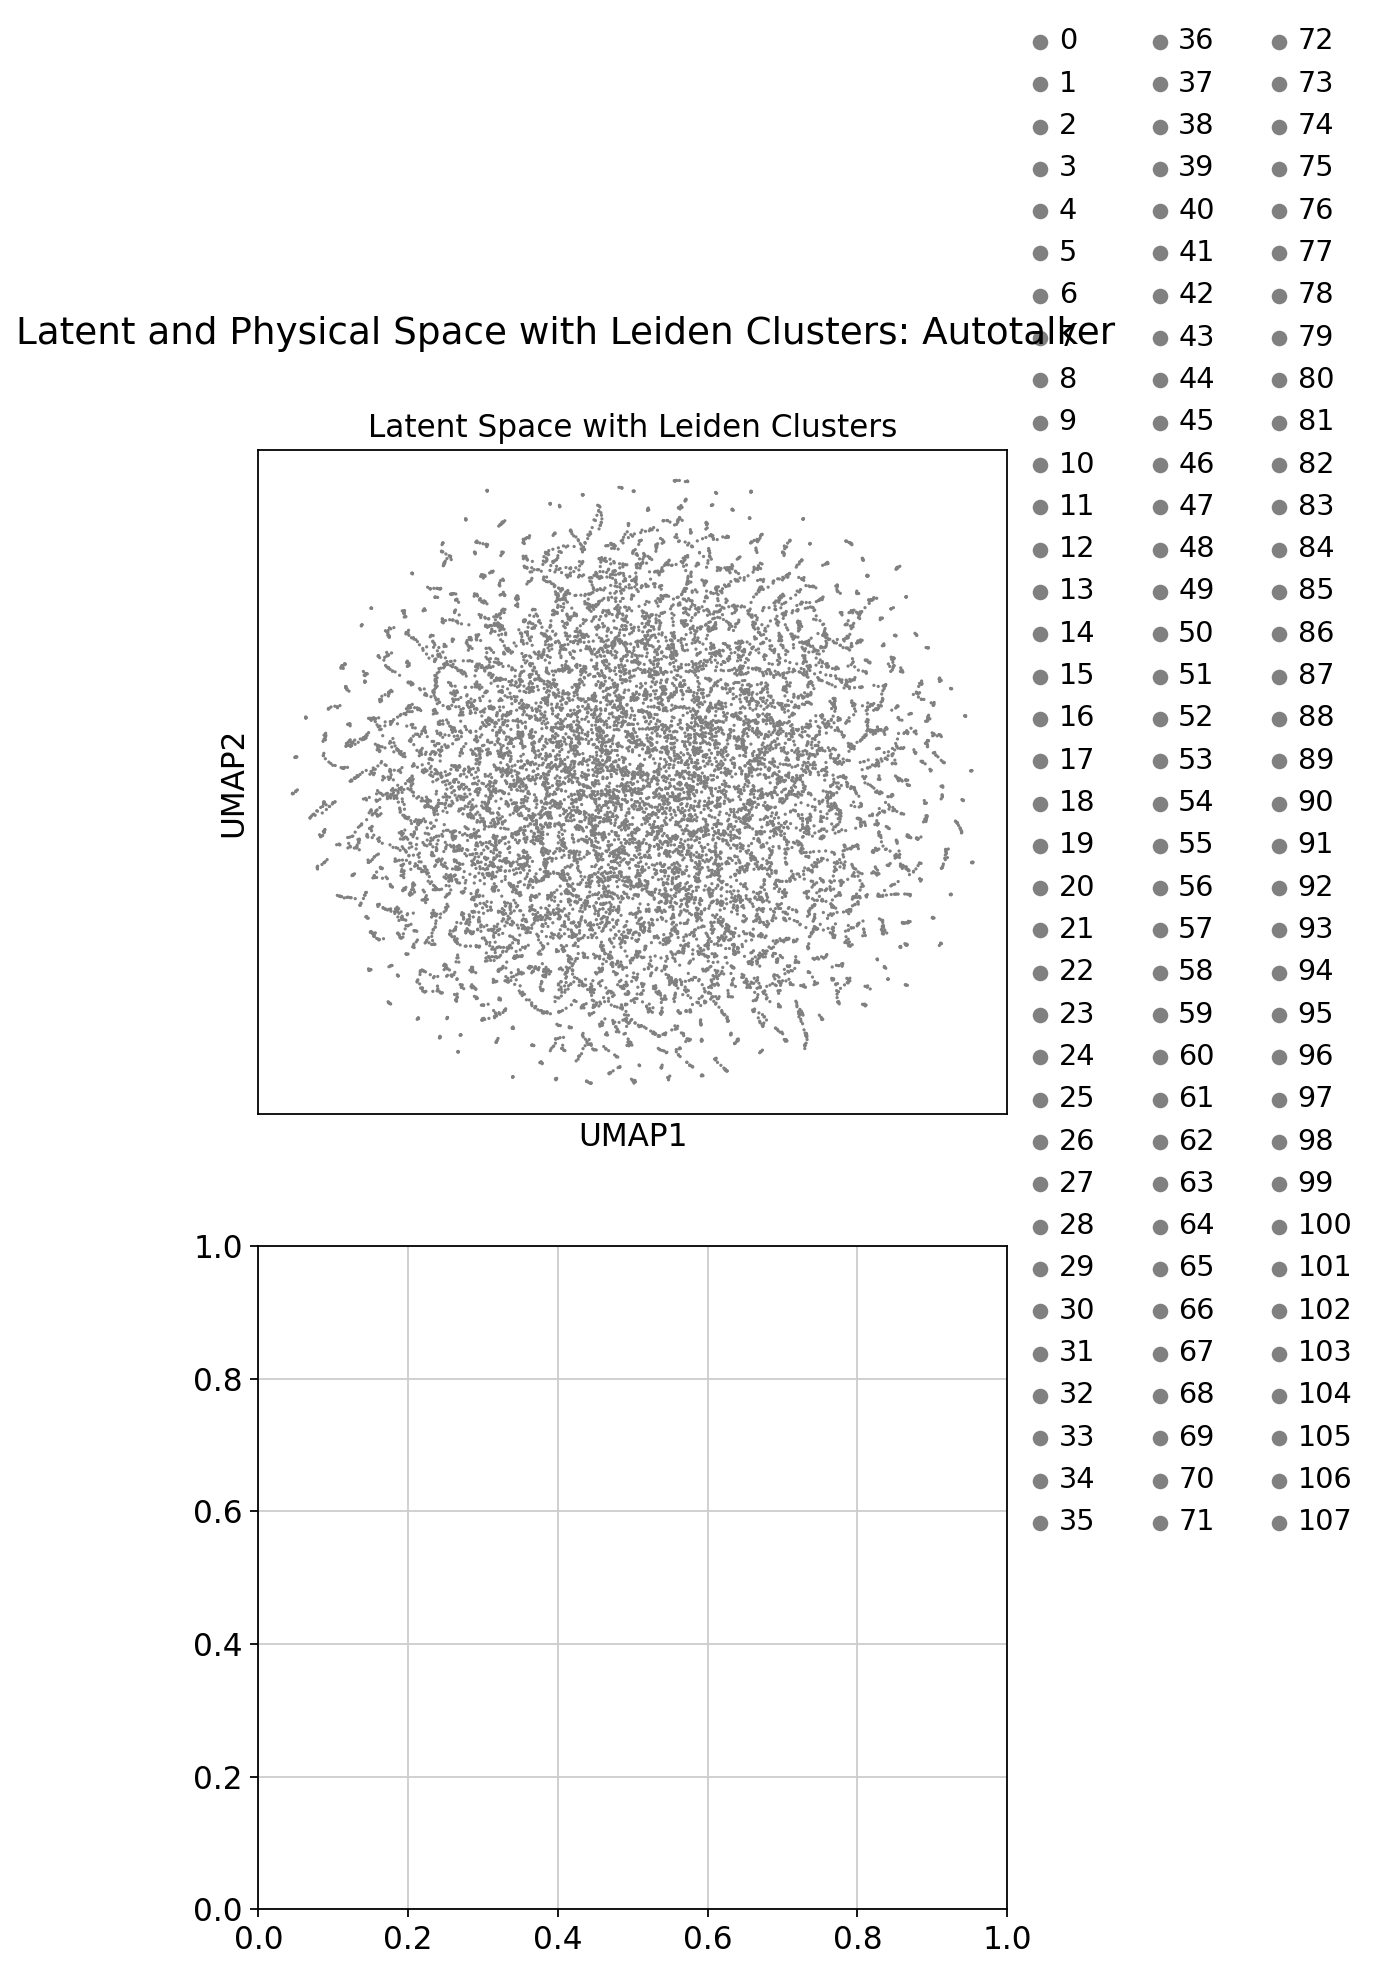

In [13]:
train_autotalker_models(dataset="seqfish_mouse_organogenesis_embryo2",
                        cell_type_key="celltype_mapped_refined")

In [ ]:
train_autotalker_models(dataset="vizgen_merfish_mouse_liver",
                        cell_type_key="Cell_Type",
                        adata_new=None,
                        n_start_run=1,
                        n_end_run=10,
                        n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20])

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
CONDITIONAL EMBEDDING INJECTION -> ['gene_expr_decoder', 'graph_decoder']
GRAPH ENCODER -> n_input: 347, n_cond_embed_input: 0, n_layers: 1, n_hidden: 522, n_latent: 522, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
COSINE SIM GRAPH DECODER -> n_cond_embed_input: 20, n_output: 522, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 522, n_cond_embed_input: 20, n_addon_input: 0, n_output: 694

--- INITIALIZING TRAINER ---
Number of training nodes: 330601
Number of validation nodes: 36734
Number of training edges: 769040
Number of validation edges: 85448

--- MODEL TRAINING ---
Epoch 1/40 |--------------------| 2.5% val_auroc_score: 0.9251; val_auprc_score: 0.9117; va

In [ ]:
# ~10% sample of the original dataset
train_autotalker_models(dataset="vizgen_merfish_mouse_liver_sample",
                        cell_type_key="Cell_Type",
                        adata_new=None,
                        n_start_run=1,
                        n_end_run=10,
                        n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20])

In [ ]:
train_autotalker_models(dataset="starmap_plus_mouse_cns",
                        cell_type_key="Main_molecular_cell_type",
                        adata_new=None,
                        n_start_run=1,
                        n_end_run=10,
                        n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20])

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
CONDITIONAL EMBEDDING INJECTION -> ['gene_expr_decoder', 'graph_decoder']
GRAPH ENCODER -> n_input: 1022, n_cond_embed_input: 0, n_layers: 1, n_hidden: 732, n_latent: 732, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
COSINE SIM GRAPH DECODER -> n_cond_embed_input: 3, n_output: 732, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 732, n_cond_embed_input: 3, n_addon_input: 0, n_output: 2044

--- INITIALIZING TRAINER ---
Number of training nodes: 82121
Number of validation nodes: 9125
Number of training edges: 195913
Number of validation edges: 21768

--- MODEL TRAINING ---
Epoch 1/40 |--------------------| 2.5% val_auroc_score: 0.9751; val_auprc_score: 0.9628; val_

In [ ]:
train_autotalker_models(dataset="nanostring_cosmx_human_nsclc",
                        cell_type_key="cell_type",
                        adata_new=None,
                        n_start_run=1,
                        n_end_run=10,
                        n_neighbor_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20])

/root/miniconda3/envs/autotalker/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/root/miniconda3/envs/autotalker/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
CONDITIONAL EMBEDDING INJECTION -> ['gene_expr_decoder', 'graph_decoder']
GRAPH ENCODER -> n_input: 960, n_cond_embed_input: 0, n_layers: 1, n_hidden: 1055, n_latent: 1055, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
COSINE SIM GRAPH DECODER -> n_cond_embed_input: 20, n_output: 1055, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 1055, n_cond_embed_input: 20, n_addon_input: 0, n_output: 1920

--- INITIALIZING TRAINER ---
Number of training nodes: 75259
Number of validation nodes: 8362
Number of training edges: 175515
Number of validation edges: 19501

--- MODEL TRAINING ---
Epoch 1/40 |--------------------| 2.5% val_auroc_score: 0.9581; val_auprc_score: 0.9529;